In [55]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2

In [2]:
def clahe(image, clip_limit, tile_size):
  # Convert the image to float32 and normalize it to [0, 1]
  image = image.astype(np.float32) / 255.0

  # Get the shape and size of the image
  height, width = image.shape
  image_size = height * width

  # Compute the number of tiles in each dimension
  num_tiles_x = int(np.ceil(width / tile_size))
  num_tiles_y = int(np.ceil(height / tile_size))

  # Pad the image if necessary to make it divisible by the tile size
  pad_x = (num_tiles_x * tile_size) - width
  pad_y = (num_tiles_y * tile_size) - height
  image = np.pad(image, ((0, pad_y), (0, pad_x)), mode="reflect")

  # Create an empty array for the output image
  output = np.zeros_like(image)

  # Loop over the tiles
  for i in range(num_tiles_x):
    for j in range(num_tiles_y):
      # Get the coordinates of the current tile
      x1 = i * tile_size
      x2 = (i + 1) * tile_size
      y1 = j * tile_size
      y2 = (j + 1) * tile_size

      # Get the tile data
      tile = image[y1:y2, x1:x2]

      # Compute the histogram and the cumulative distribution function of the tile
      hist, bins = np.histogram(tile.flatten(), bins=256, range=(0, 1))
      cdf = hist.cumsum()
      cdf = cdf / cdf[-1] # Normalize the cdf to [0, 1]

      # Apply the clip limit to the histogram
      clip_value = clip_limit * hist.max()
      excess = hist - clip_value
      excess = excess[excess > 0].sum()

      # Redistribute the excess pixels uniformly
      hist = np.clip(hist, 0, clip_value)
      step = excess / 256
      hist = hist + step

      # Recompute the cdf after clipping
      cdf = hist.cumsum()
      cdf = cdf / cdf[-1]

      # Interpolate the cdf values for the tile pixels
      tile = np.interp(tile.flatten(), bins[:-1], cdf)

      # Reshape the tile and store it in the output image
      tile = tile.reshape((tile_size, tile_size))
      output[y1:y2, x1:x2] = tile

  # Crop the output image to the original size
  output = output[:height, :width]

  # Convert the output image to uint8 and scale it to [0, 255]
  output = (output * 255).astype(np.uint8)

  # Return the output image
  return output


In [3]:
def clip_histogram(histogram, clip_limit):
    """
    Clip the histogram based on the specified clip_limit.
    """
    clipped_histogram = np.minimum(histogram, clip_limit)
    excess = np.sum(histogram) - np.sum(clipped_histogram)
    num_bins = len(histogram)
    average_bin_increment = excess / num_bins
    clipped_histogram=clipped_histogram.astype(np.float64)
    clipped_histogram += average_bin_increment.astype(np.float64)
    return clipped_histogram



In [4]:
def compute_cumulative_histogram(image):
    """
    Compute the cumulative histogram for a given image.
    """
    histogram, _ = np.histogram(image.flatten(), bins=255, range=[0, 255])
    cumulative_histogram = np.cumsum(histogram)
    return cumulative_histogram

In [5]:
def adaptive_histogram_equalization(image, window_size=10, clip_limit=5.0):
    """
    Apply adaptive histogram equalization to the given image.
    """
    if len(image.shape) == 3:
        # Convert to grayscale if the image is in color
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    height, width = image.shape
    equalized_image = np.zeros_like(image, dtype=np.uint8)

    for i in range(0, height, window_size):
        for j in range(0, width, window_size):
            window = image[i:i + window_size, j:j + window_size]
            
            # Compute the cumulative histogram for the window
            window_cumulative_histogram = compute_cumulative_histogram(window)
            
            # Clip the cumulative histogram based on the specified clip_limit
            clipped_histogram = clip_histogram(window_cumulative_histogram, clip_limit)
            
            # Normalize the clipped histogram to [0, 255]
            normalized_histogram = (clipped_histogram / np.max(clipped_histogram) * 255).astype(int)
            
            # Map the pixel values in the window using the normalized histogram
            equalized_window = np.interp(window, range(255), normalized_histogram)
            
            equalized_image[i:i + window_size, j:j + window_size] = equalized_window

    return equalized_image

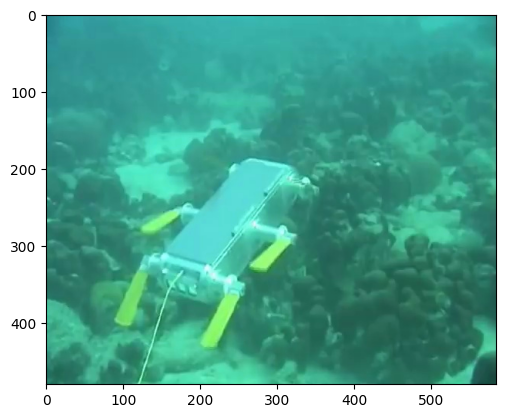

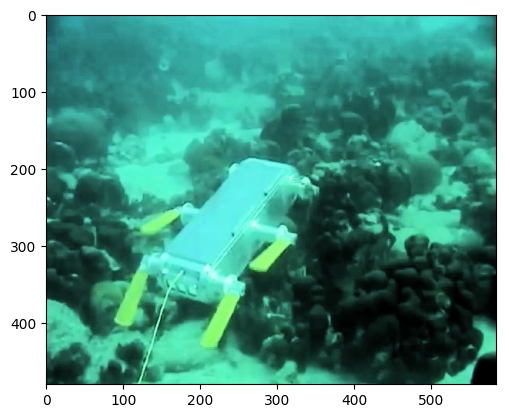

In [6]:

# Example usage:
# Load an image
image =cv2.imread('../images/d_r_160_.jpg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
h,s,v=cv2.split(image)

# Apply adaptive histogram equalization
result_image = clahe(v,clip_limit=5,tile_size=v.shape[1])
corrected_image=cv2.merge([h,s,result_image])

# Display the original and equalized images
# cv2.imshow('Original Image', image)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_HSV2RGB))
plt.show()
# cv2.imshow('Equalized Image', result_image)
plt.imshow(cv2.cvtColor(corrected_image,cv2.COLOR_HSV2RGB))
plt.show()
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [7]:
image=cv2.imread('../images/d_r_160_.jpg')
img=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
h,s,v=cv2.split(img)
mask=cv2.createCLAHE(5,[10,10])
v=mask.apply(v)
img=cv2.merge([h,s,v])
img=cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
arr=np.random.randint(0,255,size=5000)

In [9]:
hist,bins=np.histogram(arr,bins=255)

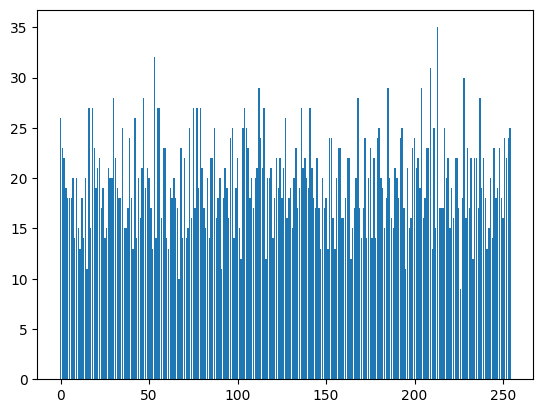

In [10]:
plt.bar(np.arange(255),hist)
plt.show()

In [11]:
pdf=hist/hist.sum()

In [12]:
cdf=pdf.cumsum()

In [13]:
adjusted=cdf*255

In [14]:
adjusted=np.round(adjusted)
print(adjusted)

[  1.   2.   4.   5.   6.   6.   7.   8.   9.  10.  11.  12.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  23.  23.  24.  25.  26.  27.
  28.  29.  30.  32.  33.  33.  34.  36.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  56.
  57.  58.  59.  60.  61.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  70.  71.  72.  73.  75.  75.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  90.  91.  92.  93.  94.  95.  97.
  97.  98. 100. 100. 101. 102. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 114. 115. 116. 117. 118. 119. 120. 121. 121. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 131. 132. 134. 134. 135. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 151. 153. 154.
 155. 155. 156. 157. 159. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 175. 177. 177. 179. 180. 181.
 182. 183. 183. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 194.
 196. 

In [15]:
arr_adjusted=np.interp(arr,bins[:-1],adjusted)

In [16]:
hist2,bins2=np.histogram(arr_adjusted.astype(np.uint8))

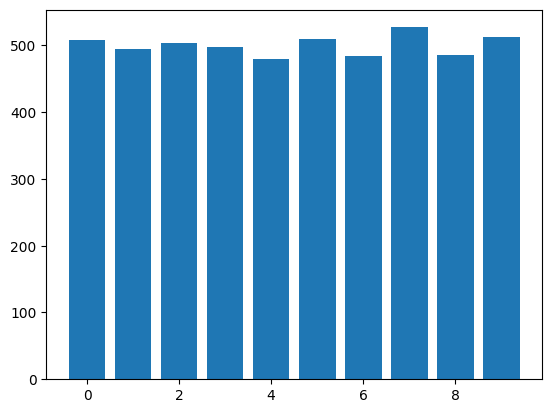

In [17]:
plt.bar(range(len(hist2)),hist2)
plt.show()

In [18]:
tan_arr=np.tan(arr)

In [19]:
tan_hist,tan_bins=np.histogram(tan_arr,bins=255)

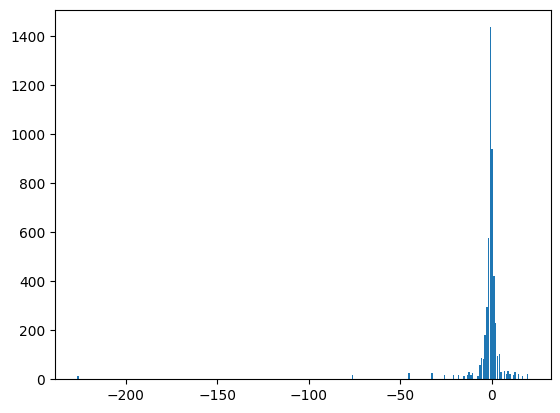

In [20]:
plt.bar(tan_bins[:-1],tan_hist)
plt.show()

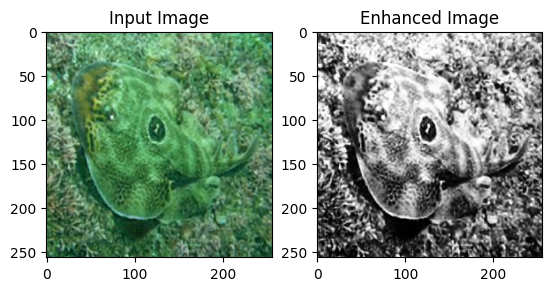

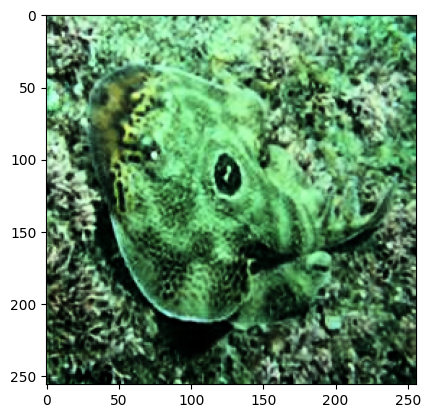

In [21]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage import exposure,io,color

# Sample input image
I = io.imread("../images/test1.jpg")
img=color.rgb2hsv(I)
h,s,v=img[:,:,0],img[:,:,1],img[:,:,2]

# 1. Apply arctangent
I_atan = np.arctan(v)

# 2. Calculate weighted histogram 
hist, bins = np.histogram(I_atan.flatten(), bins=256, density=True) 
cdf = hist.cumsum() # cdf
cdf /= cdf[-1] # normalize cdf

# 3. Define desired CDF for mapping
t = np.linspace(15,230,230-15)
st = np.arctan(t-15)
cdf_desired = st.cumsum()/st.sum() 

# 4. Use histogram equalization to match CDFs 
I_enhanced = exposure.equalize_hist(I_atan, cdf_desired)

# Display results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(I, cmap='gray')
ax2.imshow(I_enhanced, cmap='gray')
ax1.set_title('Input Image')
ax2.set_title('Enhanced Image')
plt.show()
enhanced_image=np.zeros(shape=I.shape)
enhanced_image[:,:,0],enhanced_image[:,:,1],enhanced_image[:,:,2]=h,s,I_enhanced
enhanced_image=color.hsv2rgb(enhanced_image)
plt.imshow(enhanced_image)
plt.show()

In [22]:
from skimage import filters,io

In [23]:
img=io.imread('../images/test1.jpg')

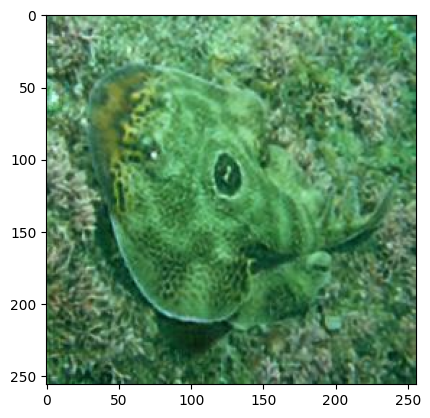

In [24]:
plt.imshow(img)
plt.show()

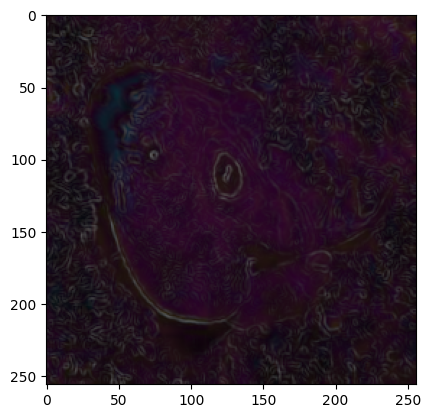

In [25]:
sobel=filters.sobel(img)
plt.imshow(sobel)

In [26]:
img.shape,sobel.shape


((256, 256, 3), (256, 256, 3))

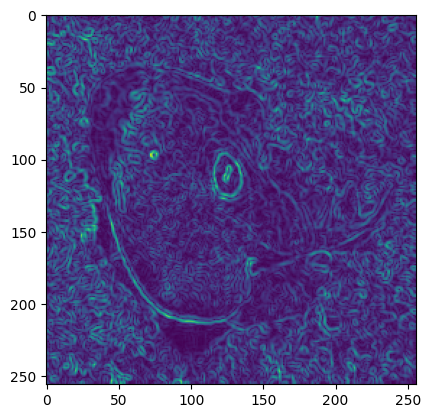

In [27]:
R=img[:,:,0]
s_r=filters.sobel(R)
plt.imshow(s_r)

In [28]:
def calculate_uicm(image:np.ndarray,alpha_R,alpha_L)->float:
    R,G,B=image[:,:,0],image[:,:,1],image[:,:,2]
    RG=(R-G)
    YB=(0.5*(R+G)-B)
    rows,cols=image.shape[0],image.shape[1]
    K=rows*cols
    RG=RG.flatten().sort()
    YB=YB.flatten().sort()
    T_alpha_L=np.ceil(K*alpha_L)
    T_alpha_R=np.floor(K*alpha_R)
    sum_RG=np.sum(RG[T_alpha_L+1:K-T_alpha_R])
    mean_RG=sum_RG/(K-T_alpha_L-T_alpha_R)
    sum_YB=np.sum(YB[T_alpha_L+1:K-T_alpha_R])
    mean_YB=sum_YB/(K-T_alpha_L-T_alpha_R)
    var_RG=np.sum(np.power(RG[T_alpha_L+1:K-T_alpha_R]-mean_RG,2))/(K-T_alpha_L-T_alpha_R)
    var_YB=np.sum(np.power(YB[T_alpha_L+1:K-T_alpha_R]-mean_YB,2))/(K-T_alpha_L-T_alpha_R)
    UICM=-0.0268*np.sqrt(mean_RG**2 + mean_YB**2) + 0.1586*np.sqrt(var_RG + var_YB)
    return UICM


In [29]:
R,G,B=img[:,:,0],img[:,:,1],img[:,:,2]
RG=(R-G)
YB=(0.5*(R+G)-B)
rows,cols=img.shape[0],img.shape[1]
K=rows*cols

In [30]:
RG=RG.flatten()

In [31]:
np.sort(RG)

array([151, 151, 153, ..., 254, 255, 255], dtype=uint8)

In [32]:
RG=RG.sort()

In [33]:
print(RG)

None


In [34]:
np.ceil(0.1*K).astype(int)

6554

In [35]:
x=np.array([1,2,3,4,5,6,7,8,np.nan,9,10,11,12,13,14,15,16,17,18,19,20])

In [36]:
print(x)

[ 1.  2.  3.  4.  5.  6.  7.  8. nan  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]


In [37]:
np.clip(x,0,10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., nan,  9., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10.])

In [39]:
import numpy as np

# Create a NumPy array with NaN values
arr = np.array([1, 2, np.nan, 4, np.nan])

# Replace NaN values with 0
arr_replaced = np.nan_to_num(arr, nan=255)

print(arr_replaced)


[  1.   2. 255.   4. 255.]


In [40]:
import numpy as np

# Create a sample array
arr = np.array([1, 2, 0, 4, 0, 6, 0])

# Replace 0 values with a new value
new_value = 10
arr = np.where(arr == 0, new_value, arr)

print(arr)


[ 1  2 10  4 10  6 10]


In [60]:
def count_edges(image, threshold1=100, threshold2=200):
    # Detect edges in the image using the Canny edge detector
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(image, threshold1=threshold1, threshold2=threshold2)
    num_edges = cv2.countNonZero(edges)
    return num_edges

In [37]:
test1=[{'UCIQE': 34.93973084112976, 'UIQM': 1.3434524334343814, 'UIConM': -0.17917221868469824, 'UISM': 5.634690138222357, 'UICM': 11.351874790096485, 'CCF': 9.5278},
{'UCIQE': 28.69444779899385, 'UIQM': 1.0164243175449008, 'UIConM': -0.1896032495219515, 'UISM': 4.560673223368842, 'UICM': 12.324326691486352, 'CCF': 3.3443} ,
{'UCIQE': 27.42386763154391, 'UIQM': 1.0070790392229139, 'UIConM': -0.18644471488983072, 'UISM': 4.983893175854492, 'UICM': 7.160679912719654, 'CCF': 2.9163},
{'UCIQE': 31.121986578142835, 'UIQM': 1.5356004633909257, 'UIConM': -0.13788276678815237, 'UISM': 5.548128245309055, 'UICM': 13.837249952086626, 'CCF': 8.2847},
{'UCIQE': 40.455614651062426, 'UIQM': 1.0599940915910642, 'UIConM': -0.1276492701836105, 'UISM': 4.566192983279091, 'UICM': 5.9567992665323155, 'CCF': 2.9447},
{'UCIQE': 15.051278161070874, 'UIQM': 0.6487016314413543, 'UIConM': -0.13525254215824134, 'UISM': 4.433076516943146, 'UICM': -6.2701223416168945, 'CCF': 2.2326},
{'UCIQE': 32.71226938060928, 'UIQM': 1.5696655177498502, 'UIConM': -0.15005173742952138, 'UISM': 5.67063074067684, 'UICM': 15.305256626232177, 'CCF': 5.7699},
{'UCIQE': 35.16369714336984, 'UIQM': 1.044748101620299, 'UIConM': -0.18910959201457445, 'UISM': 4.728803089507266, 'UICM': 11.505534525479135, 'CCF': 3.4144},
{'UCIQE': 32.67623432503775, 'UIQM': 1.5745673984148145, 'UIConM': -0.14279487569751836, 'UISM': 5.650876575306818, 'UICM': 14.76588882298044, 'CCF': 7.9874},
{'UCIQE': 32.252530181440335, 'UIQM': 0.7440154039325886, 'UIConM': -0.12719044975642646, 'UISM': 2.511980042288331, 'UICM': 16.204670654574326, 'CCF': 7.3586},
{'UCIQE': 38.559437369725146, 'UIQM': 0.8477321652993893, 'UIConM': -0.18961652532516382, 'UISM': 4.312919346515606, 'UICM': 8.93840586058117, 'CCF': 3.3787}]

In [38]:
test10=[{'UCIQE': 32.78751279360318, 'UIQM': 1.3284969652492535, 'UIConM': -0.1767105480266764, 'UISM': 5.778051228188644, 'UICM': 9.008214890954726, 'CCF': 10.3650},
{'UCIQE': 27.44296224239993, 'UIQM': 1.0955599937042626, 'UIConM': -0.1839681856788502, 'UISM': 4.854556820299293, 'UICM': 11.338681522250871, 'CCF': 2.9986},
{'UCIQE': 27.13359300095187, 'UIQM': 1.0860769077224113, 'UIConM': -0.18003809107881352, 'UISM': 5.176303834443255, 'UICM': 7.134913916503551, 'CCF': 2.8592},
{'UCIQE': 31.89856871126751, 'UIQM': 1.5181359453826764, 'UIConM': -0.14790588668779492, 'UISM': 5.901089748993329, 'UICM': 10.79262621205033, 'CCF': 9.7171} ,
{'UCIQE': 34.65186063190625, 'UIQM': 1.1803303755065437, 'UIConM': -0.181591481368514, 'UISM': 5.50300821007165, 'UICM': 7.253052284015375, 'CCF': 2.9785},
{'UCIQE': 9.26897818803349, 'UIQM': 0.6702568557796998, 'UIConM': -0.11841361825850072, 'UISM': 4.320495628502202, 'UICM': -6.461748012673143, 'CCF': 2.1368},
{'UCIQE': 30.097515266004915, 'UIQM': 1.359581429973162, 'UIConM': -0.1886005554915755, 'UISM': 5.272329002841185, 'UICM': 16.913696506496102, 'CCF': 3.0221},
{'UCIQE': 32.92365500678849, 'UIQM': 1.0572461943030287, 'UIConM': -0.18317893763355642, 'UISM': 4.949969411222181, 'UICM': 8.88084691100613, 'CCF': 3.0544},
{'UCIQE': 31.565763834840745, 'UIQM': 1.4448518269104704, 'UIConM': -0.17187451465656522, 'UISM': 5.435058751336168, 'UICM': 16.112834393351694, 'CCF': 7.9157},
{'UCIQE': 30.429425987893314, 'UIQM': 0.8415167410741171, 'UIConM': -0.12246772728462929, 'UISM': 2.9248103312132456, 'UICM': 14.740394171190811, 'CCF': 9.3653},
{'UCIQE': 29.227409590536126, 'UIQM': 1.056761932991237, 'UIConM': -0.18391335924957275, 'UISM': 4.759621705682207, 'UICM': 10.950038178307754, 'CCF': 3.3748}]

In [39]:
test11=[{'UCIQE': 34.62862829345593, 'UIQM': 0.8866418550746569, 'UIConM': -0.16256414219151338, 'UISM': 4.151482839531106, 'UICM': 8.578884756682234, 'CCF': 19.5889},
{'UCIQE': 29.20518305498552, 'UIQM': 0.6163839394301023, 'UIConM': -0.14954198481132153, 'UISM': 3.196359045877487, 'UICM': 7.345977711999936, 'CCF': 10.3330},
{'UCIQE': 27.423953248261352, 'UIQM': 0.7771392724199507, 'UIConM': -0.13875887980816515, 'UISM': 3.844736670690926, 'UICM': 4.88982824620755, 'CCF': 2.6583},
{'UCIQE': 37.103196405735886, 'UIQM': 1.0821397425518238, 'UIConM': -0.15737673831245047, 'UISM': 4.597310089220136, 'UICM': 10.185217223178077, 'CCF': 29.3227},
{'UCIQE': 36.229890496366124, 'UIQM': 0.7469739714371557, 'UIConM': -0.10694822205118726, 'UISM': 3.4590921801156775, 'UICM': 3.825391097468289, 'CCF': 10.3431},
{'UCIQE': 15.29949438248155, 'UIQM': 0.5458418921614323, 'UIConM': -0.1069666321054683, 'UISM': 3.591667603108531, 'UICM': -4.692898981199857, 'CCF': 2.3692},
{'UCIQE': 38.02059616210086, 'UIQM': 0.9494850862206542, 'UIConM': -0.14874375350291302, 'UISM': 4.017566809092292, 'UICM': 10.457487567186707, 'CCF': 22.5680},
{'UCIQE': 35.03539827141767, 'UIQM': 0.6734678294938183, 'UIConM': -0.14574097674744735, 'UISM': 3.227010367945797, 'UICM': 8.567353971793365, 'CCF': 9.8335},
{'UCIQE': 37.82114960825614, 'UIQM': 0.9652082761255488, 'UIConM': -0.12220449803362499, 'UISM': 3.785983788171712, 'UICM': 10.075354797803598, 'CCF': 36.6107},
{'UCIQE': 32.44344874720655, 'UIQM': 0.40176529534126026, 'UIConM': -0.11582769515803193, 'UISM': 1.8115167916484416, 'UICM': 9.962522881772589, 'CCF': 11.0054},
{'UCIQE': 28.65982195383562, 'UIQM': 0.5812355293202537, 'UIConM': -0.1495624107844833, 'UISM': 3.173873192545603, 'UICM': 6.337633434017733, 'CCF': 10.2031}]

In [40]:
test12=[{'UCIQE': 32.81706946704319, 'UIQM': 0.9249292536018886, 'UIConM': -0.16427230571298423, 'UISM': 3.934621653543484, 'UICM': 12.424051557664194, 'CCF': 19.1519},
{'UCIQE': 30.579820662325773, 'UIQM': 0.6298455467035141, 'UIConM': -0.14408495498560114, 'UISM': 2.90291827182049, 'UICM': 10.20428087216111, 'CCF': 13.8956},
{'UCIQE': 27.423950299956388, 'UIQM': 0.718002756038441, 'UIConM': -0.1419082206780331, 'UISM': 3.3629638128378887, 'UICM': 8.237021400623556, 'CCF': 2.7005},
{'UCIQE': 36.04471792227053, 'UIQM': 0.911913837855924, 'UIConM': -0.16830038647594847, 'UISM': 4.116711342855066, 'UICM': 10.566430853839766, 'CCF': 23.7552},
{'UCIQE': 35.64779123809987, 'UIQM': 0.9466149894950435, 'UIConM': -0.11180840059728325, 'UISM': 3.7327927249496438, 'UICM': 8.654960016768813, 'CCF': 14.1383},
{'UCIQE': 14.999080072724771, 'UIQM': 0.43253566788599385, 'UIConM': -0.10438473536805759, 'UISM': 3.2419912690101897, 'UICM': -5.376510974868753, 'CCF': 2.3133},
{'UCIQE': 36.83023674560697, 'UIQM': 0.8266526043743647, 'UIConM': -0.1473447294217749, 'UISM': 3.7125614044335182, 'UICM': 9.11825648038364, 'CCF': 15.3493} ,
{'UCIQE': 33.14241382214209, 'UIQM': 0.7358734875729692, 'UIConM': -0.14311670712777413, 'UISM': 3.005781659547429, 'UICM': 12.764231436260433, 'CCF': 13.5521},
{'UCIQE': 35.13721007514293, 'UIQM': 0.8305567855243493, 'UIConM': -0.1336597390784391, 'UISM': 3.6618146553160984, 'UICM': 8.05307031690244, 'CCF': 30.6543},
{'UCIQE': 29.602118456398845, 'UIQM': 0.39997081875850304, 'UIConM': -0.10987639282370765, 'UISM': 1.7883733221580214, 'UICM': 9.386710779710683, 'CCF': 14.5569},
{'UCIQE': 28.863106168837955, 'UIQM': 0.6222743992208708, 'UIConM': -0.14452523037834908, 'UISM': 2.8026013490345165, 'UICM': 11.042102022081185, 'CCF': 12.9443}]

In [53]:
def plot_hists(arr,folder)->None:
    data=pd.DataFrame(arr)
    plt.bar(['clahe','grey_world','max_rgb','msr','msrcp','msrcr','processed','raw','ssr','wcid','white_balance'],data['UCIQE'],label='UCIQE',color=['red','blue','green','yellow','orange','purple','pink','black','brown','grey','cyan'])
    plt.xticks(rotation=90)
    plt.title('UCIQE')
    plt.savefig(f'D:/MSc Books/Sem 4/Project/underwater_image_enhancement/images/bar_charts/{folder}/UCIQE.png')
    plt.close()
    plt.bar(['clahe','grey_world','max_rgb','msr','msrcp','msrcr','processed','raw','ssr','wcid','white_balance'],data['UIQM'],label='UIQM',color=['red','blue','green','yellow','orange','purple','pink','black','brown','grey','cyan'])
    plt.xticks(rotation=90)
    plt.title('UIQM')
    plt.savefig(f'D:/MSc Books/Sem 4/Project/underwater_image_enhancement/images/bar_charts/{folder}/UIQM.png')
    plt.close()
    plt.bar(['clahe','grey_world','max_rgb','msr','msrcp','msrcr','processed','raw','ssr','wcid','white_balance'],data['UIConM'],label='UIConM',color=['red','blue','green','yellow','orange','purple','pink','black','brown','grey','cyan'])
    plt.xticks(rotation=90)
    plt.title('UIConM')
    plt.savefig(f'D:/MSc Books/Sem 4/Project/underwater_image_enhancement/images/bar_charts/{folder}/UIConM.png')
    plt.close()
    plt.bar(['clahe','grey_world','max_rgb','msr','msrcp','msrcr','processed','raw','ssr','wcid','white_balance'],data['UISM'],label='UISM',color=['red','blue','green','yellow','orange','purple','pink','black','brown','grey','cyan'])
    plt.xticks(rotation=90)
    plt.title('UISM')
    plt.savefig(f'D:/MSc Books/Sem 4/Project/underwater_image_enhancement/images/bar_charts/{folder}/UISM.png')
    plt.close()
    plt.bar(['clahe','grey_world','max_rgb','msr','msrcp','msrcr','processed','raw','ssr','wcid','white_balance'],data['UICM'],label='UICM',color=['red','blue','green','yellow','orange','purple','pink','black','brown','grey','cyan'])
    plt.xticks(rotation=90)
    plt.title('UICM')
    plt.savefig(f'D:/MSc Books/Sem 4/Project/underwater_image_enhancement/images/bar_charts/{folder}/UICM.png')
    plt.close()
    plt.bar(['clahe','grey_world','max_rgb','msr','msrcp','msrcr','processed','raw','ssr','wcid','white_balance'],data['CCF'],label='CCF',color=['red','blue','green','yellow','orange','purple','pink','black','brown','grey','cyan'])
    plt.xticks(rotation=90)
    plt.title('CCF')
    plt.savefig(f'D:/MSc Books/Sem 4/Project/underwater_image_enhancement/images/bar_charts/{folder}/CCF.png')
    plt.close()
    


In [54]:
arrs=[test1,test10,test11,test12]
folders=['test1','test10','test11','test12']
for i in range(len(arrs)):
    plot_hists(arrs[i],folders[i])

In [62]:
files=['test1.png','test10.png','test11.png','test12.png']
folders=['clahe','grey_world','max_rgb','msr','msrcp','msrcr','processed','raw','ssr','wcid','white_balance']
for i in range(len(files)):
    print(files[i])
    for folder in folders:
        img=cv2.imread(f'D:/MSc Books/Sem 4/Project/underwater_image_enhancement/images/{folder}/{files[i]}')
        num_edges=count_edges(img)
        print(f'{folder}:{num_edges}')

test1.png
clahe:38020
grey_world:19387
max_rgb:21602
msr:36897
msrcp:13458
msrcr:5300
processed:38291
raw:21127
ssr:37285
wcid:10238
white_balance:20123
test10.png
clahe:51369
grey_world:36991
max_rgb:38101
msr:55918
msrcp:41676
msrcr:4512
processed:43419
raw:37759
ssr:48639
wcid:23330
white_balance:37840
test11.png
clahe:18999
grey_world:10709
max_rgb:10566
msr:22716
msrcp:10444
msrcr:4402
processed:17687
raw:9440
ssr:16494
wcid:7293
white_balance:11066
test12.png
clahe:17576
grey_world:8438
max_rgb:8929
msr:18669
msrcp:6818
msrcr:4159
processed:15331
raw:8196
ssr:14904
wcid:5832
white_balance:9094
